In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU, Bidirectional
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import nltk
from google.colab import drive
drive.mount('/content/drive')
nltk.download('wordnet') # You need to download an additional package first time.
nltk.download('averaged_perceptron_tagger') # You need to download an additional package first time.
nltk.download('universal_tagset') # You need to download an additional package first time.
nltk.download('stopwords')
nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
remove = ('headers', 'footers', 'quotes')
train_raw = datasets.fetch_20newsgroups(subset='train', remove=remove)
test_raw  = datasets.fetch_20newsgroups(subset='test',  remove=remove)

In [3]:
def preprocess(text):
  pattern = '<[^>]*>' # html 태그 제거
  text = re.sub(pattern=pattern,repl=' ',string=text)
  
  pattern = '[\r|\n]' # \r,\n 제거
  text = re.sub(pattern=pattern,repl=' ',string=text)
  
  pattern= '[^\w\s]' # 특수기호 제거
  text = re.sub(pattern=pattern,repl=' ',string=text)
  
  pattern=re.compile(r'\s+')  #  이중 space 제거
  text = re.sub(pattern=pattern,repl=' ',string=text)
  
  tokens = nltk.tokenize.word_tokenize(text)
  
  lemmatizer = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  tokens = [tk for tk in tokens if tk not in stopwords]
  lemmas = [lemmatizer.lemmatize(tk) for tk in tokens]
  text =  ' '.join(lemmas)
  return text

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train_raw.data, train_raw.target, test_size=0.2, random_state=42) 
X_test, y_test = test_raw.data, test_raw.target

tokenizer = Tokenizer(num_words=10000)
processed = [preprocess(d) for d in X_train]
tokenizer.fit_on_texts(processed)
word_index = tokenizer.word_index
maxlen=400

X_train = [preprocess(d) for d in X_train]
X_val = [preprocess(d) for d in X_val]
X_test = [preprocess(d) for d in X_test]

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)


In [6]:
glove_dir =  '/content/drive/My Drive/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 300
max_features = 10000
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if i < max_features:
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [7]:
input_tensor = keras.Input(shape=(maxlen,))
x = layers.Embedding(10000, 300)(input_tensor)
x = layers.Dropout(0.2)(x)
x = Bidirectional(GRU(150))(x)
x = layers.BatchNormalization()(x)
output_tensor = layers.Dense(20, activation = "softmax")(x)

model = Model(input_tensor, output_tensor)
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 400, 300)          3000000   
_________________________________________________________________
dropout (Dropout)            (None, 400, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               406800    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense (Dense)                (None, 20)                6020      
Total params: 3,414,020
Trainable params: 413,420
Non-trainable params: 3,000,600
_____________________________________________

In [8]:
ES = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)
MC = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/exp/model{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

In [9]:
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_val, y_val), callbacks=[ES,MC])

Epoch 1/50
19/19 [==============================] - 15s 316ms/step - loss: 2.9868 - acc: 0.1384 - val_loss: 2.7919 - val_acc: 0.2227
Epoch 2/50
19/19 [==============================] - 5s 288ms/step - loss: 2.2265 - acc: 0.3141 - val_loss: 2.4968 - val_acc: 0.2572
Epoch 3/50
19/19 [==============================] - 5s 288ms/step - loss: 1.7934 - acc: 0.4302 - val_loss: 2.2970 - val_acc: 0.3102
Epoch 4/50
19/19 [==============================] - 5s 290ms/step - loss: 1.4668 - acc: 0.5402 - val_loss: 2.1964 - val_acc: 0.3654
Epoch 5/50
19/19 [==============================] - 6s 291ms/step - loss: 1.2676 - acc: 0.6070 - val_loss: 2.0510 - val_acc: 0.4269
Epoch 6/50
19/19 [==============================] - 6s 292ms/step - loss: 1.1488 - acc: 0.6464 - val_loss: 1.8737 - val_acc: 0.5223
Epoch 7/50
19/19 [==============================] - 6s 292ms/step - loss: 1.0463 - acc: 0.6800 - val_loss: 1.6849 - val_acc: 0.5859
Epoch 8/50
19/19 [==============================] - 6s 293ms/step - loss: 0

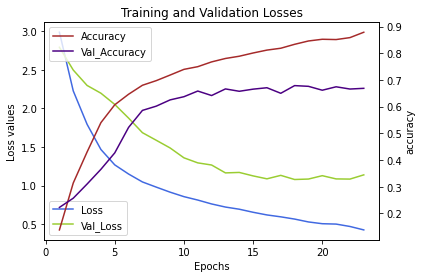

In [11]:
fig, ax1 = plt.subplots()
ax1.set_title(f'Training and Validation Losses')
x=[i for i in range(1,24)]
ax1.plot(x, history.history['loss'], c='#4169E1', label='Loss')
ax1.plot(x, history.history['val_loss'], c='#9ACD32', label='Val_Loss')
ax2 = ax1.twinx()
ax2.plot(x, history.history['acc'], c='#A52A2A', label='Accuracy')
ax2.plot(x, history.history['val_acc'], c='#4B0082', label='Val_Accuracy')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss values')
ax2.set_ylabel('accuracy')

ax1.legend(loc = 'lower left')
ax2.legend()

In [12]:
model.load_weights('/content/drive/My Drive/exp/model18-0.68.hdf5')

In [13]:
model.evaluate(X_test, y_test)

236/236 [==============================] - 5s 20ms/step - loss: 1.2383 - acc: 0.6260


[1.2382643222808838, 0.6259957551956177]

In [21]:
model.layers[1].trainable=True
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 400, 300)          3000000   
_________________________________________________________________
dropout (Dropout)            (None, 400, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               406800    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense (Dense)                (None, 20)                6020      
Total params: 3,414,020
Trainable params: 3,413,420
Non-trainable params: 600
_________________________________________________

In [23]:
ES = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)
MC = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/exp/model_finetuning{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

In [24]:
history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_val, y_val), callbacks=[ES,MC])

Epoch 1/50
19/19 [==============================] - 11s 425ms/step - loss: 0.5189 - acc: 0.8475 - val_loss: 1.0592 - val_acc: 0.6787
Epoch 2/50
19/19 [==============================] - 7s 391ms/step - loss: 0.5110 - acc: 0.8507 - val_loss: 1.0479 - val_acc: 0.6814
Epoch 3/50
19/19 [==============================] - 7s 391ms/step - loss: 0.5108 - acc: 0.8534 - val_loss: 1.0431 - val_acc: 0.6832
Epoch 4/50
19/19 [==============================] - 7s 391ms/step - loss: 0.5118 - acc: 0.8535 - val_loss: 1.0412 - val_acc: 0.6840
Epoch 5/50
19/19 [==============================] - 7s 390ms/step - loss: 0.5100 - acc: 0.8500 - val_loss: 1.0413 - val_acc: 0.6840
Epoch 6/50
19/19 [==============================] - 7s 392ms/step - loss: 0.5081 - acc: 0.8531 - val_loss: 1.0424 - val_acc: 0.6845
Epoch 7/50
19/19 [==============================] - 7s 392ms/step - loss: 0.5067 - acc: 0.8543 - val_loss: 1.0444 - val_acc: 0.6849
Epoch 8/50
19/19 [==============================] - 7s 393ms/step - loss: 0

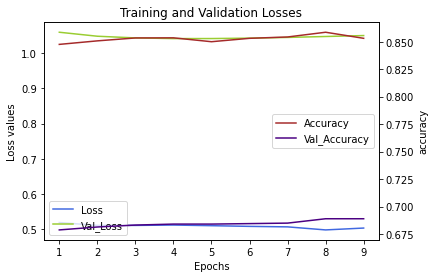

In [25]:
fig, ax1 = plt.subplots()
ax1.set_title(f'Training and Validation Losses')
x=[i for i in range(1,10)]
ax1.plot(x, history.history['loss'], c='#4169E1', label='Loss')
ax1.plot(x, history.history['val_loss'], c='#9ACD32', label='Val_Loss')
ax2 = ax1.twinx()
ax2.plot(x, history.history['acc'], c='#A52A2A', label='Accuracy')
ax2.plot(x, history.history['val_acc'], c='#4B0082', label='Val_Accuracy')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss values')
ax2.set_ylabel('accuracy')

ax1.legend(loc = 'lower left')
ax2.legend()

In [26]:
model.load_weights('/content/drive/My Drive/exp/model_finetuning04-0.68.hdf5')

In [27]:
model.evaluate(X_test, y_test)

236/236 [==============================] - 5s 20ms/step - loss: 1.2181 - acc: 0.6366


[1.218096137046814, 0.636617124080658]

In [14]:
input_cnn = keras.Input(shape=(maxlen,))
x = layers.Embedding(10000, 300)(input_cnn)
x = layers.Conv1D(300, 5, activation='relu')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(300, 5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(300, activation="relu")(x)
x=layers.Dropout(0.3)(x)
output_cnn = layers.Dense(20, activation = "softmax")(x)
cnn = Model(input_cnn, output_cnn)
cnn.layers[1].set_weights([embedding_matrix])
cnn.layers[1].trainable=False

cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 396, 300)          450300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 132, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 300)          450300    
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0   

In [15]:
ES = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)
MC = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/exp/modelcnn{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

In [16]:
cnn.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [17]:
historycnn = cnn.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_val, y_val), callbacks=[ES,MC])

Epoch 1/50
19/19 [==============================] - 32s 257ms/step - loss: 2.7878 - acc: 0.1412 - val_loss: 2.2587 - val_acc: 0.2753
Epoch 2/50
19/19 [==============================] - 4s 225ms/step - loss: 2.0994 - acc: 0.3049 - val_loss: 1.6968 - val_acc: 0.4556
Epoch 3/50
19/19 [==============================] - 4s 227ms/step - loss: 1.6266 - acc: 0.4483 - val_loss: 1.4350 - val_acc: 0.5219
Epoch 4/50
19/19 [==============================] - 4s 228ms/step - loss: 1.3657 - acc: 0.5437 - val_loss: 1.2938 - val_acc: 0.5926
Epoch 5/50
19/19 [==============================] - 4s 228ms/step - loss: 1.1868 - acc: 0.6061 - val_loss: 1.2063 - val_acc: 0.6262
Epoch 6/50
19/19 [==============================] - 4s 230ms/step - loss: 1.0114 - acc: 0.6740 - val_loss: 1.1606 - val_acc: 0.6328
Epoch 7/50
19/19 [==============================] - 4s 229ms/step - loss: 0.8741 - acc: 0.7232 - val_loss: 1.1414 - val_acc: 0.6434
Epoch 8/50
19/19 [==============================] - 4s 229ms/step - loss: 0

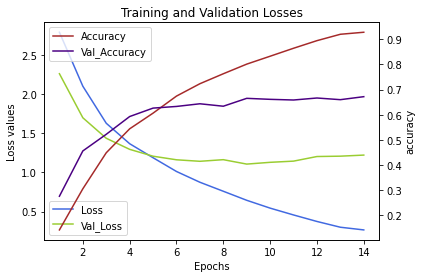

In [18]:
fig, ax1 = plt.subplots()
ax1.set_title(f'Training and Validation Losses')
x=[i for i in range(1,15)]
ax1.plot(x, historycnn.history['loss'], c='#4169E1', label='Loss')
ax1.plot(x, historycnn.history['val_loss'], c='#9ACD32', label='Val_Loss')
ax2 = ax1.twinx()
ax2.plot(x, historycnn.history['acc'], c='#A52A2A', label='Accuracy')
ax2.plot(x, historycnn.history['val_acc'], c='#4B0082', label='Val_Accuracy')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss values')
ax2.set_ylabel('accuracy')

ax1.legend(loc = 'lower left')
ax2.legend()

In [ ]:
cnn.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [38]:
cnn.load_weights('/content/drive/My Drive/exp/modelcnn09-0.67.hdf5')

In [34]:
cnn.evaluate(X_test, y_test)

236/236 [==============================] - 2s 9ms/step - loss: 1.3123 - acc: 0.6192


[1.3122599124908447, 0.6192246675491333]

In [39]:
cnn.layers[1].trainable=True
cnn.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [40]:
ES = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)
MC = keras.callbacks.ModelCheckpoint('/content/drive/My Drive/exp/modelcnn_finetuning{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

In [41]:
historycnn = cnn.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_val, y_val), callbacks=[ES,MC])

Epoch 1/50
19/19 [==============================] - 7s 341ms/step - loss: 0.5265 - acc: 0.8459 - val_loss: 1.0781 - val_acc: 0.6743
Epoch 2/50
19/19 [==============================] - 6s 336ms/step - loss: 0.5020 - acc: 0.8594 - val_loss: 1.0725 - val_acc: 0.6792
Epoch 3/50
19/19 [==============================] - 6s 338ms/step - loss: 0.5047 - acc: 0.8544 - val_loss: 1.0724 - val_acc: 0.6823
Epoch 4/50
19/19 [==============================] - 6s 339ms/step - loss: 0.4974 - acc: 0.8574 - val_loss: 1.0712 - val_acc: 0.6818
Epoch 5/50
19/19 [==============================] - 6s 340ms/step - loss: 0.4935 - acc: 0.8557 - val_loss: 1.0715 - val_acc: 0.6814
Epoch 6/50
19/19 [==============================] - 6s 342ms/step - loss: 0.4909 - acc: 0.8618 - val_loss: 1.0726 - val_acc: 0.6832
Epoch 7/50
19/19 [==============================] - 6s 339ms/step - loss: 0.4894 - acc: 0.8568 - val_loss: 1.0717 - val_acc: 0.6832
Epoch 8/50
19/19 [==============================] - 6s 339ms/step - loss: 0.

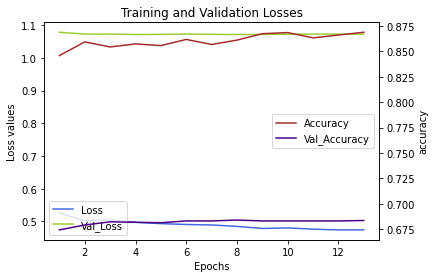

In [42]:
fig, ax1 = plt.subplots()
ax1.set_title(f'Training and Validation Losses')
x=[i for i in range(1,14)]
ax1.plot(x, historycnn.history['loss'], c='#4169E1', label='Loss')
ax1.plot(x, historycnn.history['val_loss'], c='#9ACD32', label='Val_Loss')
ax2 = ax1.twinx()
ax2.plot(x, historycnn.history['acc'], c='#A52A2A', label='Accuracy')
ax2.plot(x, historycnn.history['val_acc'], c='#4B0082', label='Val_Accuracy')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss values')
ax2.set_ylabel('accuracy')

ax1.legend(loc = 'lower left')
ax2.legend()

In [44]:
cnn.load_weights('/content/drive/My Drive/exp/modelcnn_finetuning08-0.68.hdf5')

In [45]:
cnn.evaluate(X_test, y_test)

236/236 [==============================] - 2s 9ms/step - loss: 1.2909 - acc: 0.6294


[1.2909032106399536, 0.6294476985931396]

In [57]:
y_pred = np.argmax(model.predict(X_test) + cnn.predict(X_test), axis=1)

In [52]:
print(metrics.accuracy_score(y_test, y_pred), metrics.balanced_accuracy_score(y_test, y_pred))

0.6546733935209772 0.6413757810916305


In [59]:
new_y_pred = [train_raw.target_names[i] for i in y_pred]
new_y_test = [train_raw.target_names[i] for i in y_test]

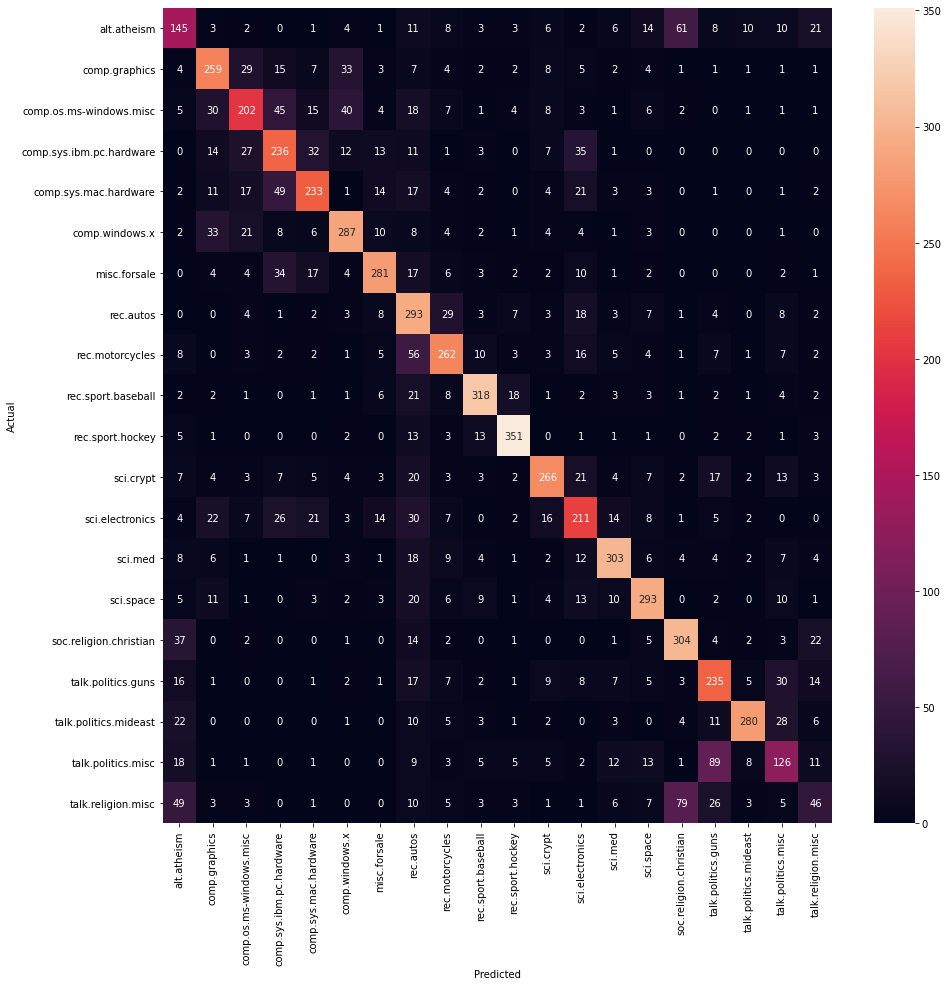

In [61]:
import seaborn as sns
import pandas as pd
plt.rcParams["figure.figsize"] = (15, 15)
data = { 'y_Actual' : new_y_test, 'y_Predicted' : new_y_pred}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()